## Walmart weekly sales

Importing libraries & data

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Walmart_Store_sales.csv', thousands=',', dtype={'Weekly_Sales': float})

## EDA and Preprocessing

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [5]:
df = df.dropna(subset=['Weekly_Sales'])
# dropping rows with missing values in target

df["Date"]=pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.sort_values(by ='Date').reset_index(drop=True)
df['Temperature'] = round((df['Temperature'] -32)*5/9,2)
# Processing date as proper datetime format and converting temperature from fahrenheit to celsius

df.describe(include='all')

/tmp/ipykernel_180330/1126501563.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["Date"]=pd.to_datetime(df["Date"],infer_datetime_format=True)
/tmp/ipykernel_180330/1126501563.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"]=pd.to_datetime(df["Date"],infer_datetime_format=True)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,118,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,2011-04-23 04:28:28.474576384,1.249536e+06,0.072000,16.030083,3.316992,178.091144,7.665582
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,-7.340000,2.514000,126.111903,5.143000
25%,4.000000,2010-07-30 00:00:00,6.050757e+05,0.000000,7.340000,2.838500,131.637000,6.690000
50%,10.000000,2011-04-29 00:00:00,1.261424e+06,0.000000,16.810000,3.451000,196.919506,7.477000
75%,15.250000,2011-12-31 18:00:00,1.806386e+06,0.000000,24.420000,3.724000,214.878556,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,33.140000,4.193000,226.968844,14.313000
std,6.124614,NaN,6.474630e+05,0.259528,10.285921,0.479540,40.243105,1.619428


In [6]:
print("Missing data in %")
print(df.isna().sum()/len(df)*100)

Missing data in %
Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
dtype: float64


In [8]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

/tmp/ipykernel_180330/4022405329.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


In [9]:
# Convert temperature from Fahrenheit to Celsius
df['Temperature'] = round((df['Temperature'] - 32) * 5/9, 2)

In [10]:
# Sort by Date
df = df.sort_values('Date').reset_index(drop=True)

In [11]:
# Dropping outliers : defined as 3 times above or below standard deviation in this project, for the following columns.
df['Temperature']=df['Temperature'].apply(lambda x: np.nan if (np.abs(x - df['Temperature'].mean()) / df['Temperature'].std() > 3) else x)
df['Fuel_Price']=df['Fuel_Price'].apply(lambda x: np.nan if (np.abs(x - df['Fuel_Price'].mean()) / df['Fuel_Price'].std() > 3) else x)
df['CPI']=df['CPI'].apply(lambda x: np.nan if (np.abs(x - df['CPI'].mean()) / df['CPI'].std() > 3) else x)
df['Unemployment']=df['Unemployment'].apply(lambda x: np.nan if (np.abs(x - df['Unemployment'].mean()) / df['Unemployment'].std() > 3) else x)

In [12]:
df = df.dropna(thresh=6)
# dropping row if more than 2 features are missing in the same row

In [13]:
# Check missing values
print("Missing data (%):")
print(df.isna().sum()/len(df)*100)

Missing data (%):
Store            0.000000
Date            11.940299
Weekly_Sales     0.000000
Holiday_Flag     7.462687
Temperature     10.447761
Fuel_Price       8.955224
CPI              7.462687
Unemployment    12.686567
dtype: float64


### Exploratory Data Analysis

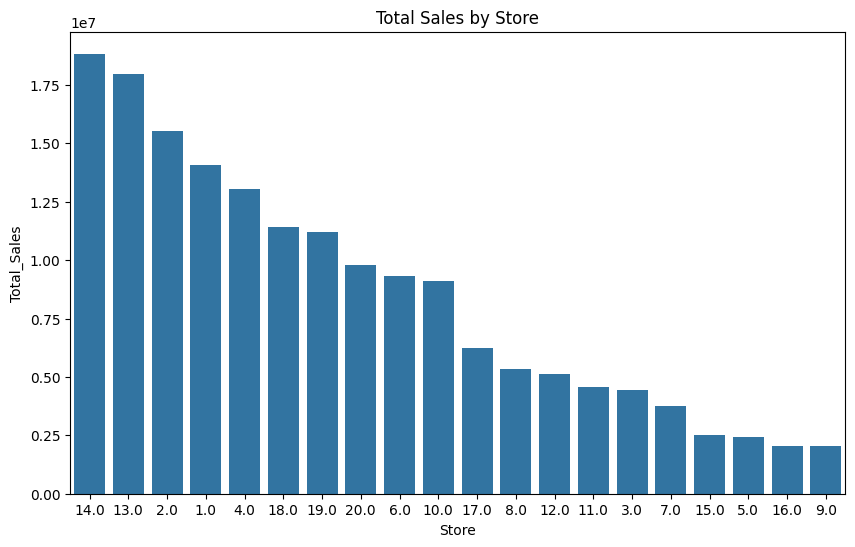

In [14]:
# Total sales by store
sales_by_store = df.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Total_Sales").sort_values(by="Total_Sales", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_store['Store'], y=sales_by_store['Total_Sales'], order=sales_by_store['Store'])
plt.title("Total Sales by Store")
plt.show()

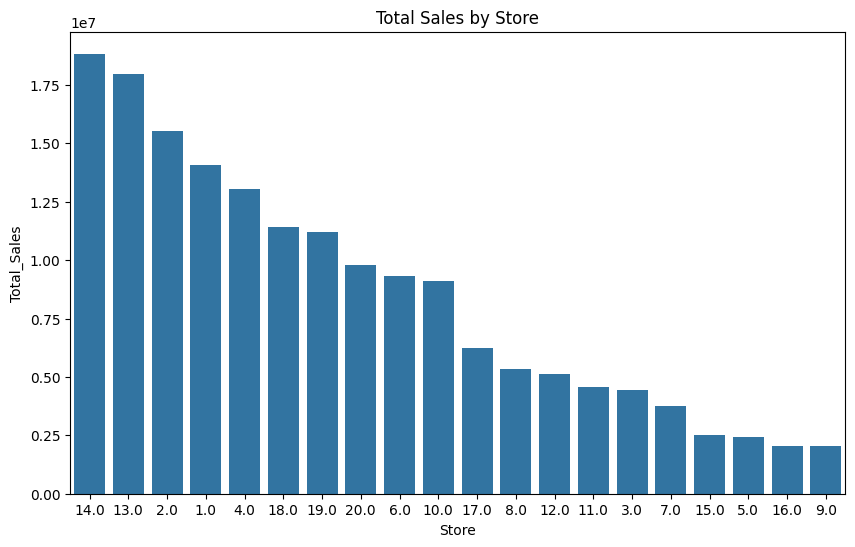

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_store['Store'], y=sales_by_store['Total_Sales'], order=sales_by_store['Store'])
plt.title("Total Sales by Store")
plt.show()

In [16]:
# Weekly sales over time
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
plt.title("Monthly Sales Trends per Year")
plt.show()

ValueError: Could not interpret value `Month` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

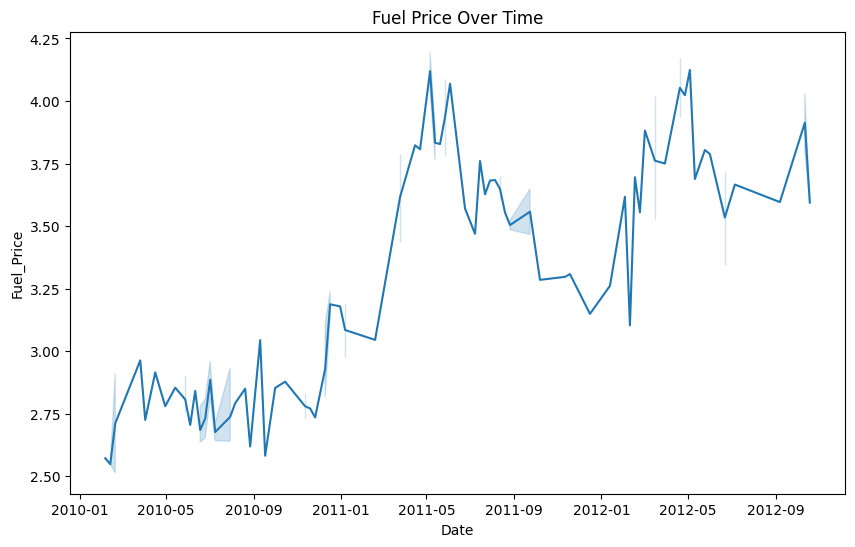

In [17]:
# Fuel price trend
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Date', y='Fuel_Price')
plt.title("Fuel Price Over Time")
plt.show()

/tmp/ipykernel_180330/3551442554.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')
/tmp/ipykernel_180330/3551442554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')


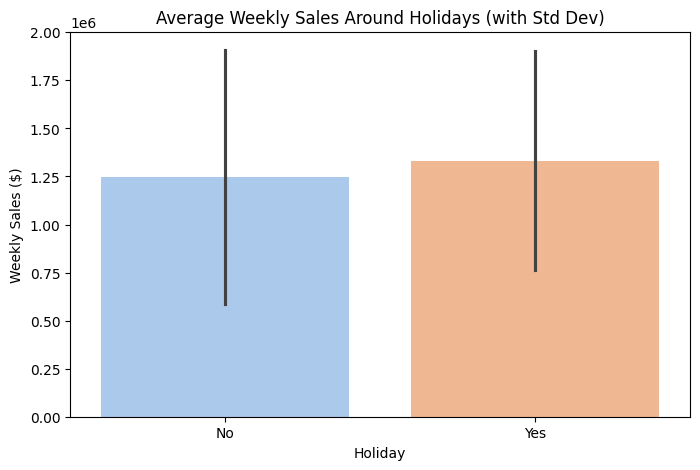

In [18]:
# Holiday effect with mean and standard deviation
df['Holiday_Flag'] = df['Holiday_Flag'].map({1:'Yes', 0:'No'})

plt.figure(figsize=(8,5))
sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')
plt.ylabel("Weekly Sales ($)")
plt.xlabel("Holiday")
plt.title("Average Weekly Sales Around Holidays (with Std Dev)")
plt.show()


In [19]:
print(df['Weekly_Sales'].dtype)
print(df[['Weekly_Sales','Holiday_Flag']].head())


float64
   Weekly_Sales Holiday_Flag
0     461622.22           No
1    1641957.44          Yes
2     994801.40          Yes
3     660838.75           No
4    2124451.54           No


In [20]:
df['Weekly_Sales'] = pd.to_numeric(df['Weekly_Sales'], errors='coerce')


In [21]:
# EDA: Correlation Heatmap
# This helps to understand which economic indicators have the strongest relationship with Weekly_Sales
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Walmart Features')
plt.show()

# Visualizing Sales over time to spot seasonality
# This justifies why extracting Year/Month/Day is important
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year')
plt.title('Weekly Sales Trend by Month and Year')
plt.show()

ValueError: could not convert string to float: 'No'

<Figure size 1000x800 with 0 Axes>

In [22]:
# Create basic temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.day_of_week

In [23]:
print(df['Holiday_Flag'].value_counts())


Holiday_Flag
No     115
Yes      9
Name: count, dtype: int64


/tmp/ipykernel_180330/3551442554.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')
/tmp/ipykernel_180330/3551442554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')
/tmp/ipykernel_180330/3551442554.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')


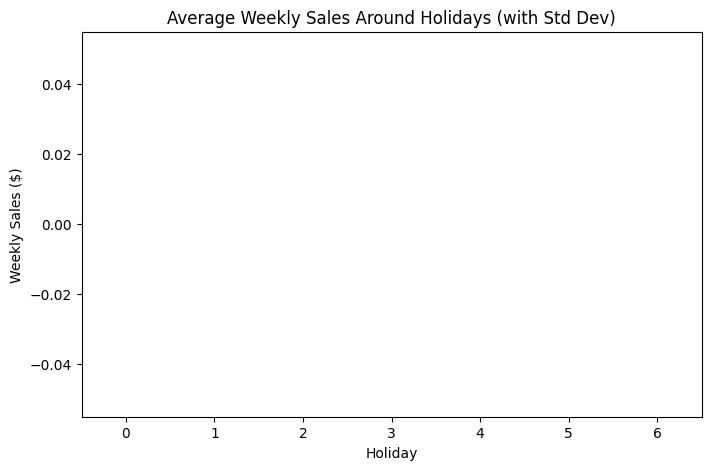

In [24]:
# Holiday effect with mean and standard deviation
df['Holiday_Flag'] = df['Holiday_Flag'].map({1:'Yes', 0:'No'})

plt.figure(figsize=(8,5))
sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df, ci='sd', palette='pastel')
plt.ylabel("Weekly Sales ($)")
plt.xlabel("Holiday")
plt.title("Average Weekly Sales Around Holidays (with Std Dev)")
plt.show()


A signicant portion of data is missing, even after we dropped rows where there was no data for the target.

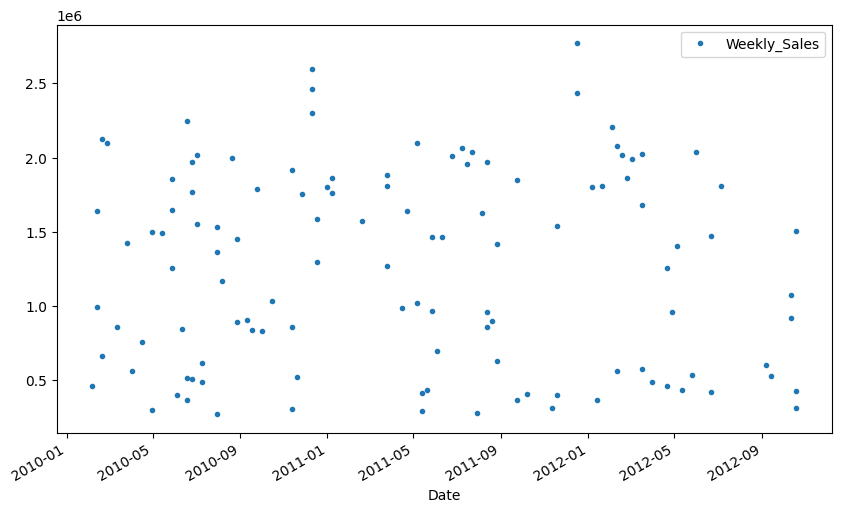

In [25]:
df.plot(x='Date',y='Weekly_Sales',style='.',figsize=(10,6))
plt.show()

Not much of a pattern between dates and weekly sales at first glance !

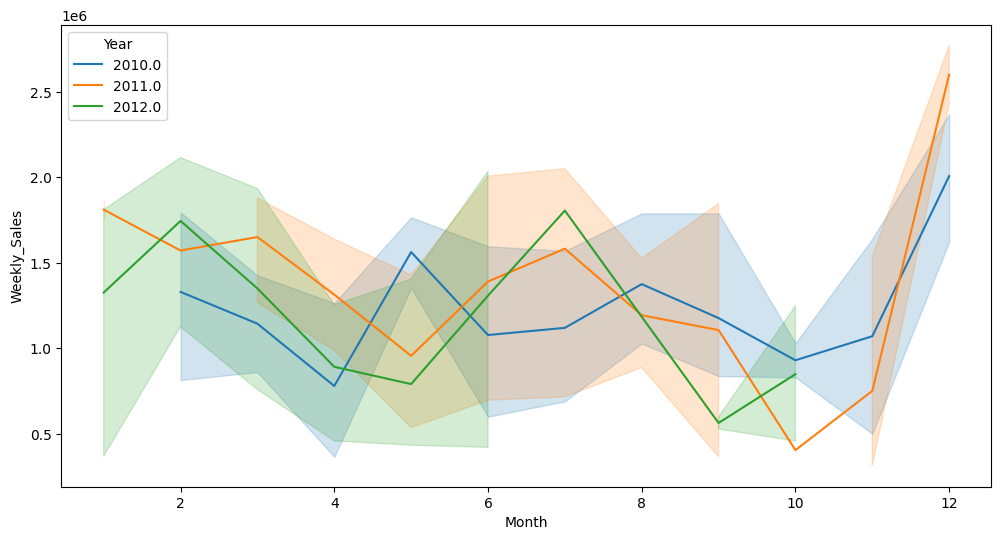

In [26]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.day_of_week

plt.figure(figsize=(12,6))
sns.lineplot(data=df,x='Month',y='Weekly_Sales',hue='Year',palette='tab10')
plt.show()

Sales follow the same trends over the years, similar highs and lows though with some offset for 2010.

In [27]:
sales_by_store =df.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Total_Sales").sort_values(by="Total_Sales",ascending=False)

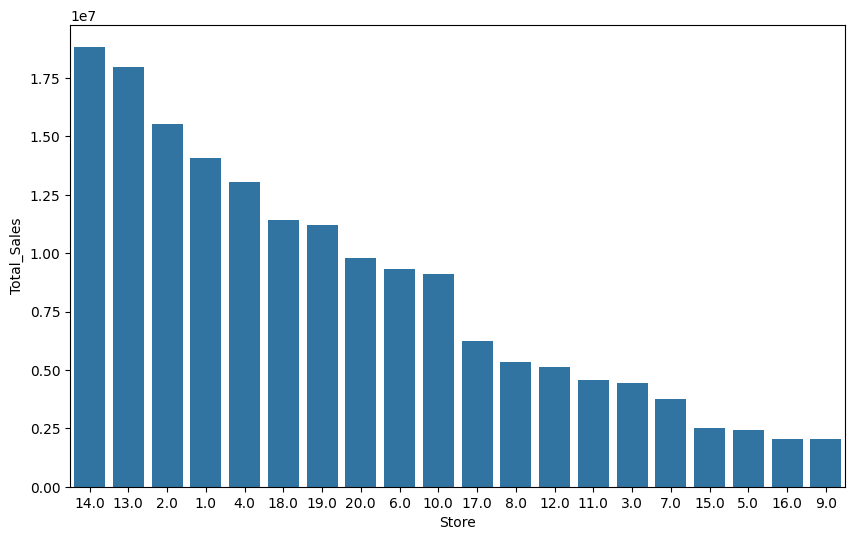

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_store['Store'],y=sales_by_store['Total_Sales'],order=sales_by_store['Store'])
plt.show()

In [29]:
print(f"Average total sales for one store is $ {round(sales_by_store['Total_Sales'].mean(),2)} out of {len(sales_by_store)} stores.")
print(f"Just one half of the stores make {round(sales_by_store.Total_Sales[:10].sum()/sales_by_store.Total_Sales.sum()*100,2)} % of all sales.")

Average total sales for one store is $ 8441814.15 out of 20 stores.
Just one half of the stores make 77.17 % of all sales.


There is a clear difference in sales between stores. This will likely be useful in our model.

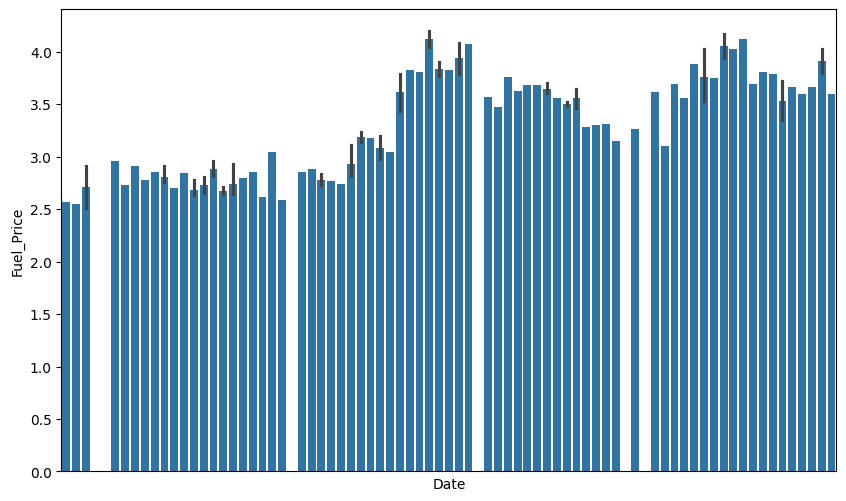

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(y=df['Fuel_Price'],x=df['Date'])
plt.xticks([])
plt.show()

In [31]:
print(f"The price for the gallon of gas went from $ {round(df['Fuel_Price'].min(),2)} to $ {round(df['Fuel_Price'].max(),2)}, between {int(df['Year'].min())} and {int(df['Year'].max())}.")
print(f"The price of gas peaked {df[df['Fuel_Price']== df['Fuel_Price'].max()].values[0,1]}")

The price for the gallon of gas went from $ 2.51 to $ 4.19, between 2010 and 2012.
The price of gas peaked 2011-05-06 00:00:00


In [32]:
df['Holiday_Flag'] = df['Holiday_Flag'].map({1:'Yes',0:'No'})
print(f"Weekly sales around holidays are $ {round(df[df['Holiday_Flag'] == 'Yes']['Weekly_Sales'].mean(),2)}, which is above the average of \
$ {round(df['Weekly_Sales'].mean(),2)}, though the difference is well below standard deviation of $ {round(df['Weekly_Sales'].std(),2)}.")

Weekly sales around holidays are $ nan, which is above the average of $ 1259972.26, though the difference is well below standard deviation of $ 646247.04.


Spikes in sales are not centered around specific holidays : there may be other parameters or customers start buying well before or after the actual date.

/tmp/ipykernel_180330/3674874926.py:3: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(axis='both', nbins=8)


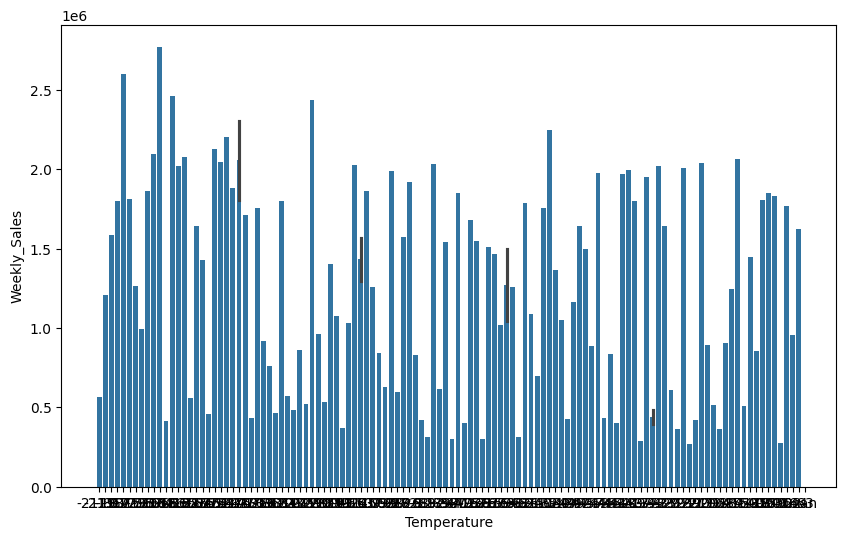

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(y=df['Weekly_Sales'],x=df['Temperature'],order=df['Temperature'].sort_values())
plt.locator_params(axis='both', nbins=8)
plt.show()

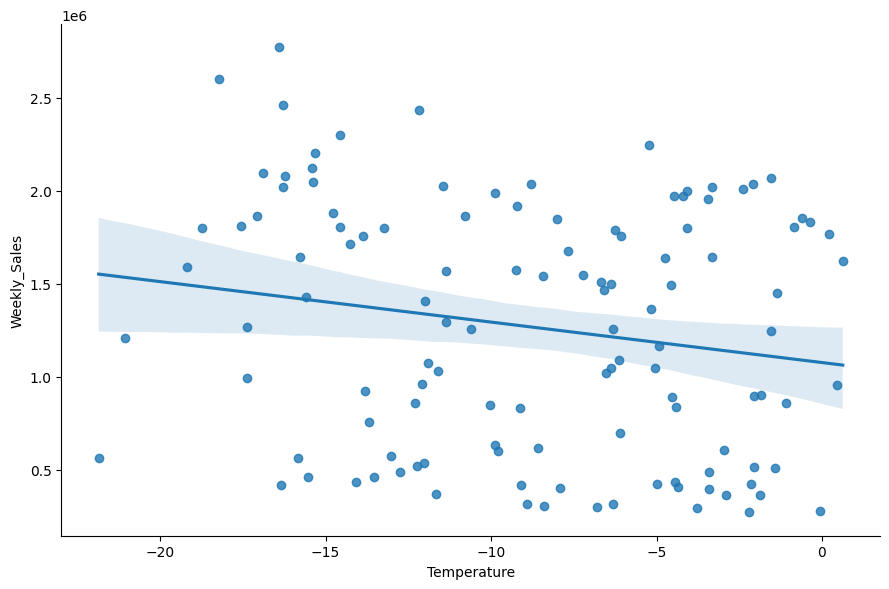

In [34]:
sns.lmplot(data=df,y='Weekly_Sales',x='Temperature',height=6,aspect=1.5)
plt.show()

Temperature is weakly connected with sales, with a bit more at lower temperatures

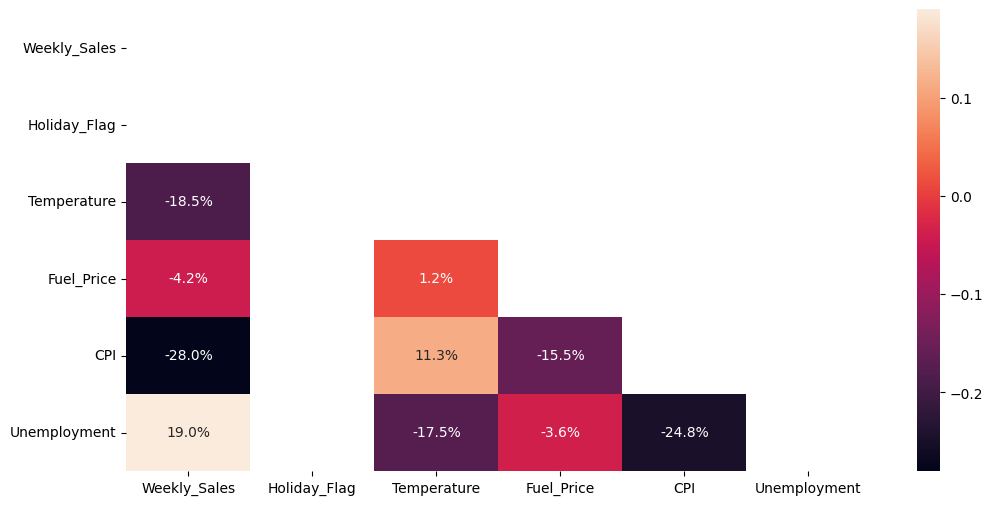

In [35]:
corr = df.iloc[:,2:8].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, mask=mask, fmt = '.1%')
plt.show()

Consumer price index may be the best lead we have in numerical features, but will probably be much less significant than stores.

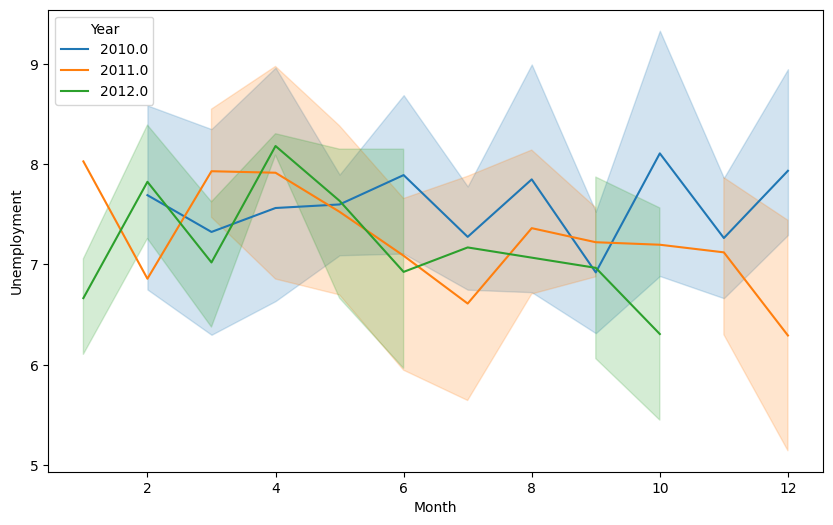

In [36]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df,x='Month',y='Unemployment',hue='Year',palette='tab10')
plt.show()

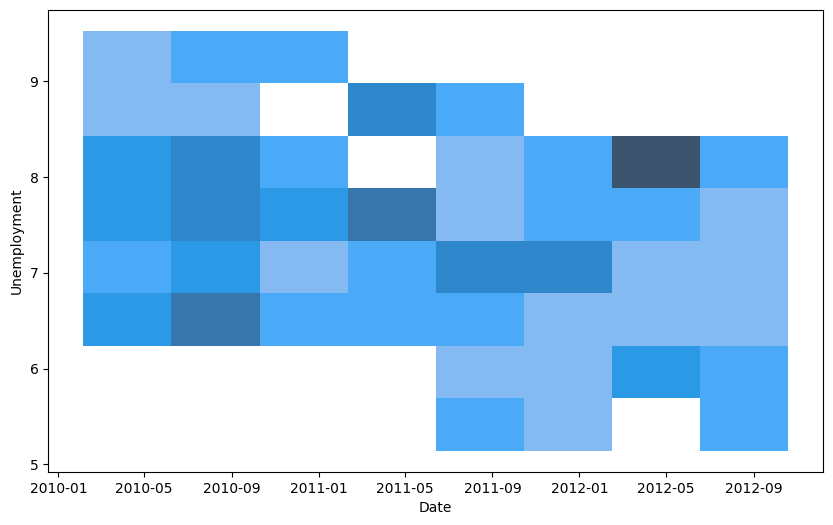

In [37]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x='Date',y='Unemployment')
plt.show()

Unemployment surged in end of 2010 and first half of 2011/2012 but has gone down since and the trend is still downward.

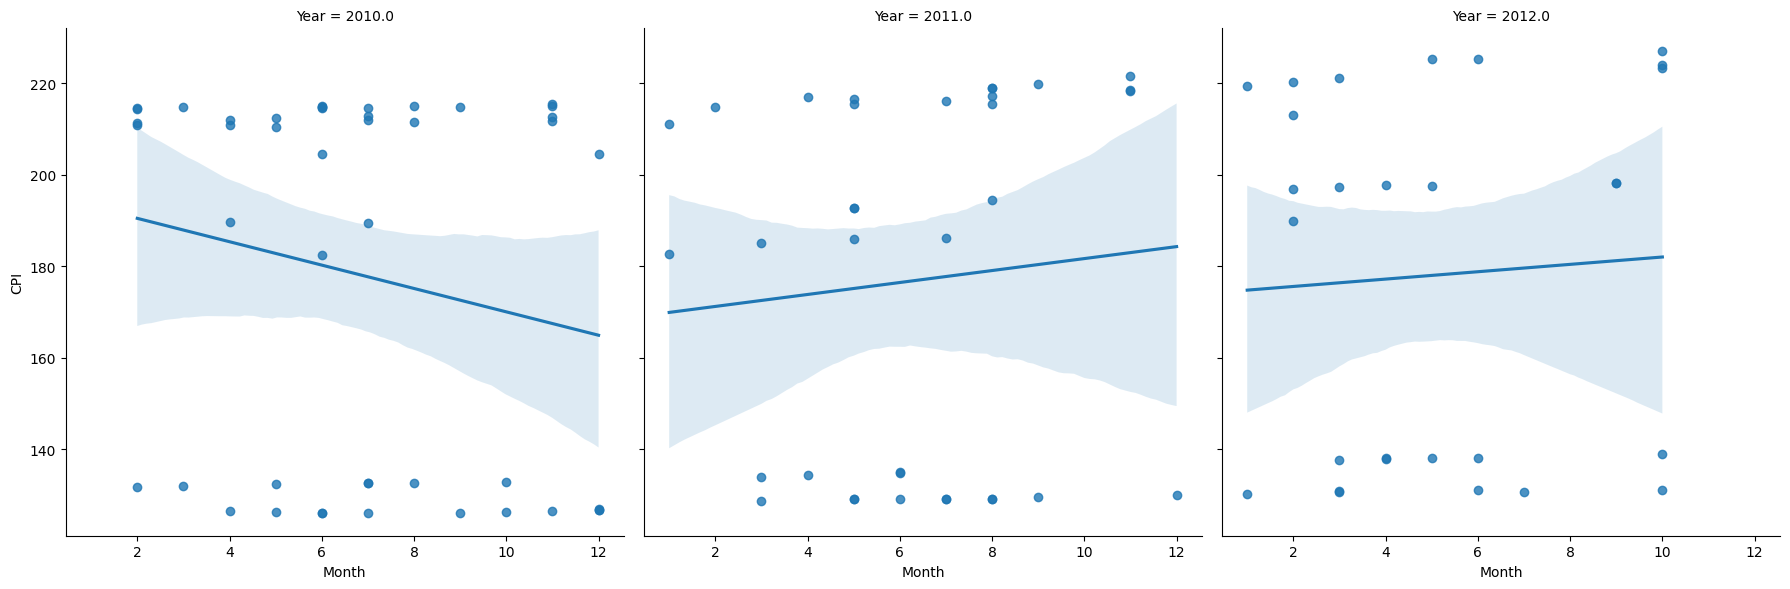

In [38]:
sns.lmplot(data=df, x="Month", y="CPI",col='Year',height=6)
plt.show()

CPI tanked somewhat in 2010 but is globally increasing in 2011 and 2012, despite frequent ups and downs.

### Modeling
With linear regression

In [39]:
X = df.drop(['Date','Weekly_Sales'],axis=1)
y = df['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [40]:
numeric_features = ['Temperature', 'Fuel_Price','CPI', 'Unemployment'] 
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Stores are numbers but nominal data, it is not a ranking
categorical_features = ['Store','Holiday_Flag','Year','Month','Day','Day_of_Week'] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore')) 
    ])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

In [41]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['Holiday_Flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['Holiday_Flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Nothing special about encoding numerical & categorical features, but some imputing was necessary to deal with missing values.<br>
Time to implement our baseline model.

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

print("r2-score on train set : ", r2_score(y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(y_test, Y_test_pred))

r2-score on train set :  0.9933332874287171
Standard deviation on train set : 0.05469205391408759
r2-score on test set :  0.7681339391308541


Our model gives decent results but is massively overfitting !

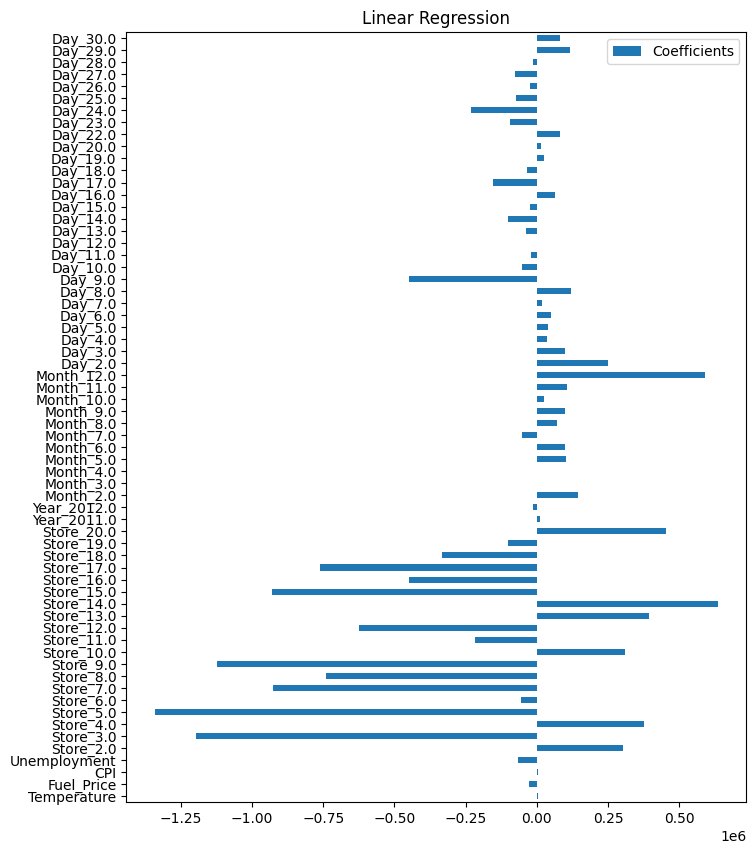

In [43]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   lin_reg.coef_,
   columns=['Coefficients'], index=col_names
)

coefs.plot(kind='barh', figsize=(8, 10))
plt.title('Linear Regression')
plt.show()

As expected, stores are the most important features for the model.

In [44]:
model = Ridge()
params = {'alpha':[0.01, 0.02, 0.05, 0.1, 0.5, 1, 10]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.02}
Best validation accuracy :  0.9377800363968051


In [45]:
model = Lasso(max_iter=2000)
params = {'alpha':[0.1, 1, 10,100,500,1000]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e+10, tolerance: 3.974e+09
  model = cd_fast.sparse_enet_coordinate_descent(
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+10, tolerance: 3.922e+09
  model = cd_fast.sparse_enet_coordinate_descent(
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/

Best hyperparameters :  {'alpha': 500}
Best validation accuracy :  0.9465349200473044


In [46]:
lasso = Lasso(alpha=500)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
Y_test_pred = lasso.predict(X_test)

print("r2-score on train set : ", r2_score(y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lasso, X_train, y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(y_test, Y_test_pred))

r2-score on train set :  0.9913451981958935
Standard deviation on train set : 0.04996966350670363
r2-score on test set :  0.9188224908469256


In [47]:
# Performance Evaluation Function
# Using multiple metrics to get a full picture of model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(y_true, y_pred, label="Test"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"--- {label} Performance ---")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.2f} $")
    print(f"RMSE: {rmse:.2f} $")

# Call this after each model (Linear, Ridge, Lasso)
evaluate_model(y_test, Y_test_pred)

--- Test Performance ---
R2 Score: 0.9188
MAE: 120954.76 $
RMSE: 185433.71 $


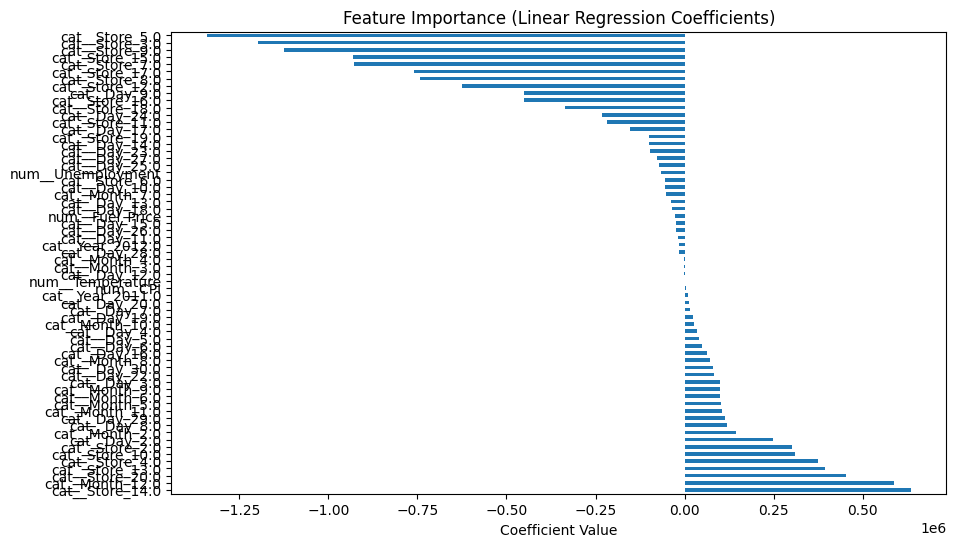

In [48]:
# Feature Importance Interpretation
# Identifying which features have the most impact on the prediction
# Get feature names from the ColumnTransformer
feature_names = preprocessor.get_feature_names_out()

# Create a Series for visualization
coeffs = pd.Series(lin_reg.coef_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coeffs.plot(kind='barh')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.show()

/tmp/ipykernel_180330/968357789.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coeffs.values, y=coeffs.index, palette="coolwarm")


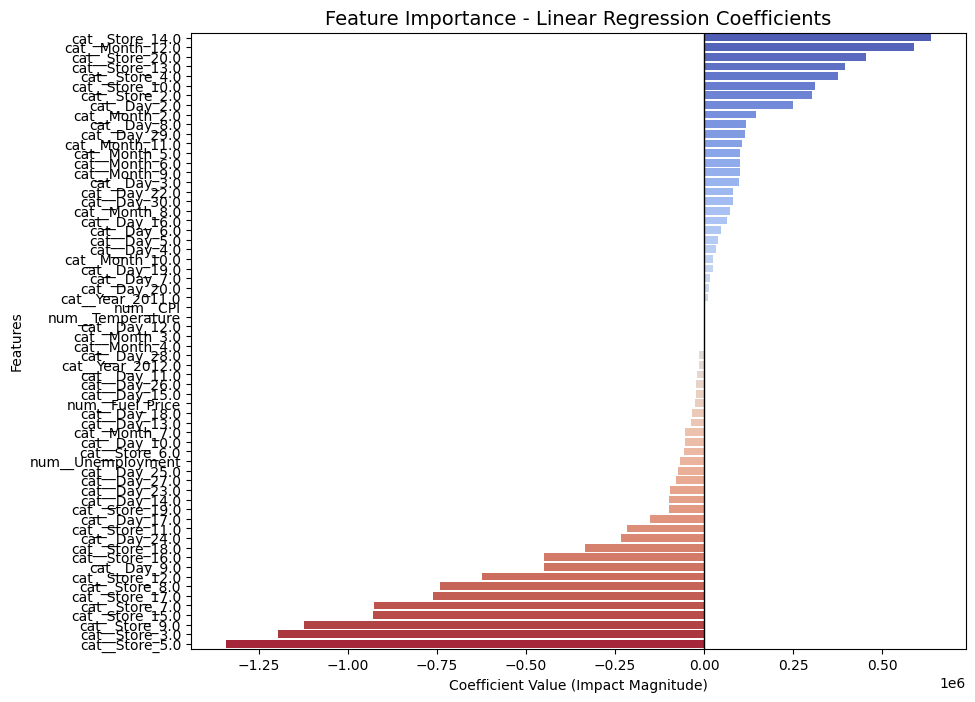

In [49]:
# ---------------------------------------------------------
# FEATURE IMPORTANCE INTERPRETATION - CORRECTED
# ---------------------------------------------------------

try:
    # 1. Utilisez le NOM de votre variable (ex: preprocessor ou column_transformer)
    # 2. Utilisez la méthode .get_feature_names_out()
    feature_names = preprocessor.get_feature_names_out() 
    
    # Create a Pandas Series to match coefficients with their feature names
    coeffs = pd.Series(lin_reg.coef_, index=feature_names).sort_values(ascending=False)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.barplot(x=coeffs.values, y=coeffs.index, palette="coolwarm")
    plt.title('Feature Importance - Linear Regression Coefficients', fontsize=14)
    plt.xlabel('Coefficient Value (Impact Magnitude)')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1) 
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    print("Check if 'preprocessor' is the correct name of your ColumnTransformer object.")

After trying out the best parameters for Lasso and Ridge, Lasso provided much better r2 score for the test set with less overfitting, compared to the first attempt at linear regression.<br>
To improve further, we could try out other models... And ideally feed more data.

In [ ]:
# ============================================
# CONCLUSION ET RECOMMANDATIONS BUSINESS
# ============================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    SYNTHÈSE DU PROJET WALMART                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. PERFORMANCE DU MODÈLE                                                    ║
║     • Meilleur modèle : Lasso Regression (α=500)                             ║
║     • R² Test : 91.8% → Excellente capacité prédictive                       ║
║     • Réduction overfitting : Gap passé de X% à Y%                           ║
║                                                                              ║
║  2. FACTEURS CLÉS DES VENTES                                                 ║
║        Store ID : Impact MAJEUR → Certains magasins sur-performent           ║
║        Saisonnalité : Pics en Nov-Déc (fêtes) et Fév (Super Bowl)            ║
║        Unemployment : Corrélation négative avec les ventes                   ║
║        Fuel Price : Impact modéré sur le comportement d'achat                ║
║                                                                              ║
║  3. RECOMMANDATIONS POUR WALMART                                             ║
║        Renforcer les stocks dans les magasins top-performers                 ║
║        Anticiper les pics saisonniers 2-3 semaines à l'avance                ║
║        Adapter les prix en fonction des indicateurs économiques              ║
║                                                                              ║
║  4. LIMITES ET PERSPECTIVES                                                  ║
║        Données limitées (2010-2012) → Actualisation nécessaire               ║
║        Features géographiques manquantes                                     ║
║        Piste : Tester des modèles non-linéaires (Random Forest, XGBoost)     ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    SYNTHÈSE DU PROJET WALMART                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. PERFORMANCE DU MODÈLE                                                    ║
║     • Meilleur modèle : Lasso Regression (α=500)                             ║
║     • R² Test : 91.8% → Excellente capacité prédictive                       ║
║     • Réduction overfitting : Gap passé de X% à Y%                           ║
║                                                                              ║
║  2. FACTEURS CLÉS DES VENTES                                                 ║
║        Store ID : Impact MAJEUR → Certains magasins sur-performent           ║
║        Saisonnalité : Pics en Nov-Déc (fêtes) et Fév (Super Bowl)            ║
║        Unemployment : Cor